In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

N = 183
learning_rate = 10**(-5)
Params = 10
K = 5
data = pd.read_csv("/content/drive/MyDrive/datasets/TrainingData_N183_p10.csv")

In [ ]:
X = data[['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']].values
Y_dummy = pd.get_dummies(data[['Ancestry']])
Y = Y_dummy.values
intercept = np.ones((N,1))
Y_dummy

,Ancestry_African,Ancestry_EastAsian,Ancestry_European,Ancestry_NativeAmerican,Ancestry_Oceanian
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
178,0,0,0,1,0
179,0,0,0,1,0
180,0,0,0,1,0
181,0,0,0,1,0


In [ ]:
#standarding the design matrix 'X'.
X_standardized = (X-np.mean(X,axis=0))/np.std(X,axis=0)

X_final = np.hstack((intercept,X_standardized))

beta = np.zeros((Params+1,5))
lamda_values = [10**(-4),10**(-3),10**(-2),10**(-1),10**(0),10**(1),10**(2),10**(3),10**(4)]
iterations = 10000
beta_lamdas = []
for lamda in lamda_values:
  for i in range(iterations):
    U = np.exp(np.dot(X_final,beta))

    P = U/np.sum(U,axis=1,keepdims=True)

    Z = np.zeros_like(beta)
    Z[0,:] = beta[0,:]

    beta = beta + learning_rate*(np.dot(np.transpose(X_final),(Y-P))-2*lamda*(beta-Z))
  beta_lamdas.append(beta)

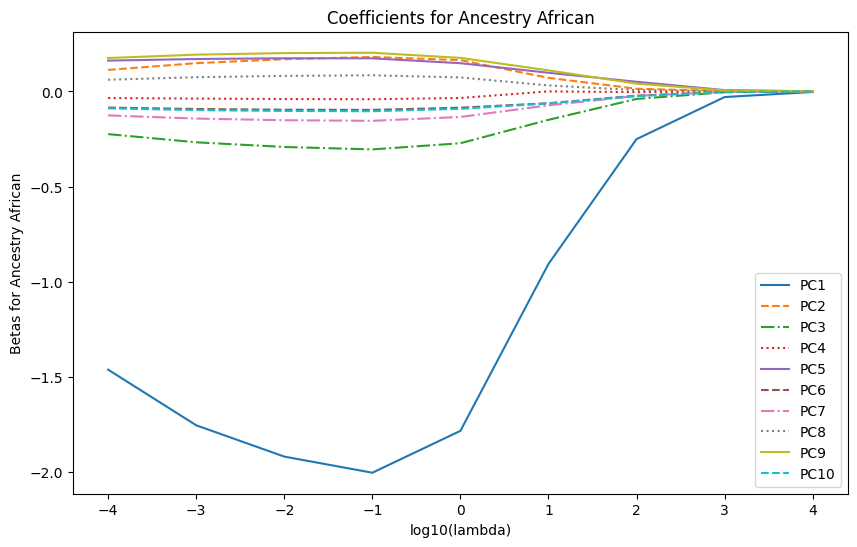

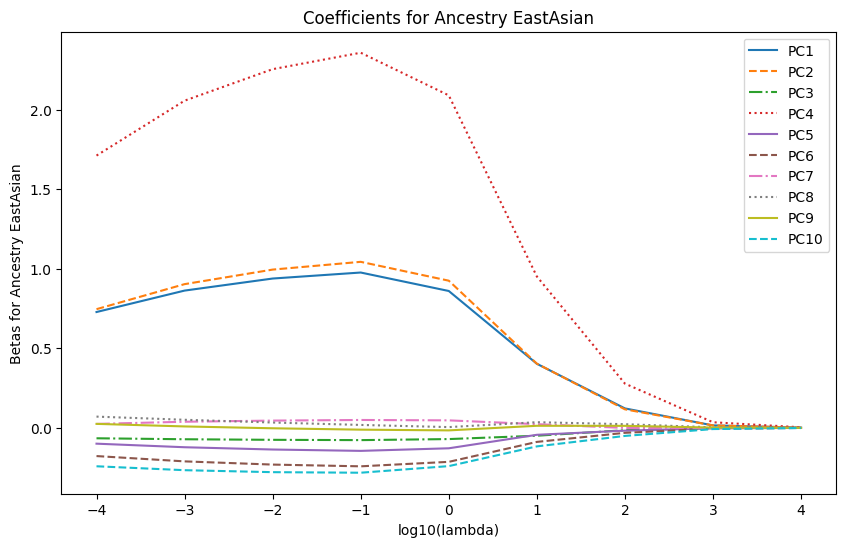

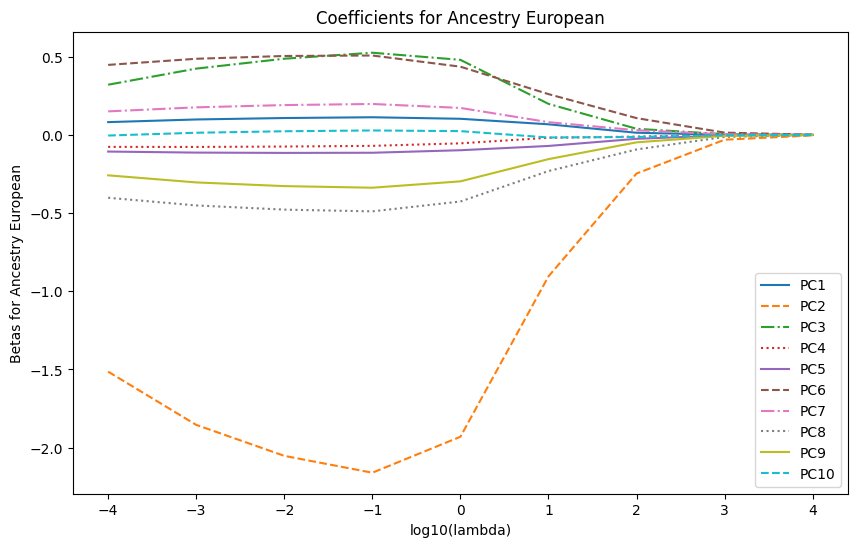

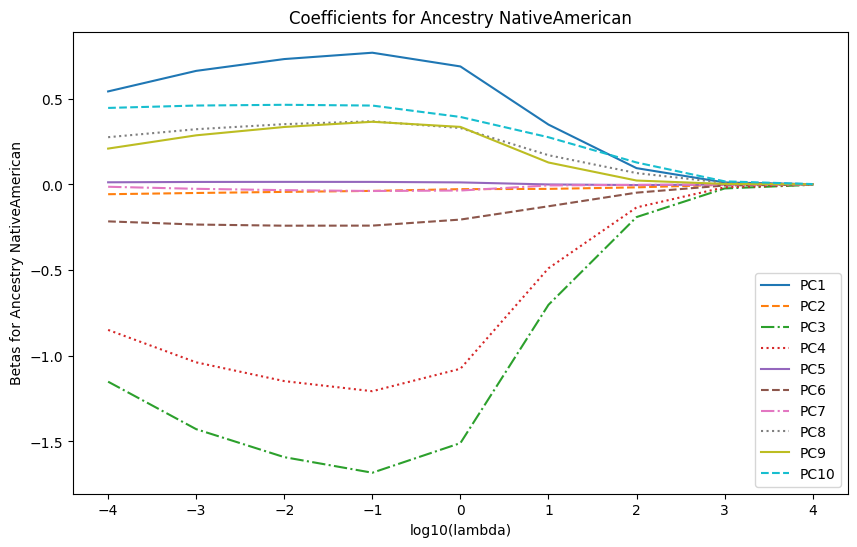

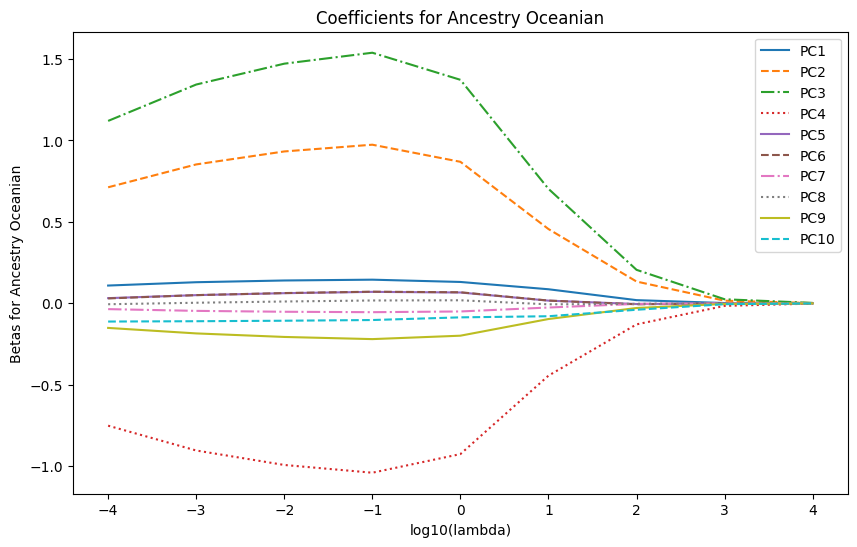

In [ ]:
#Illustrating the effect of the tuning parameter on the inferred ridge regression coefficients.
beta_lamdas = np.array(beta_lamdas)
classes = ['African','EastAsian','European','NativeAmerican','Oceanian']
feature_labels = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']
line_model = ['-','--','-.',':','-','--','-.',':','-','--']
for k in range(K):
    plt.figure(figsize=(10, 6))
    for j in range(1,len(feature_labels)+1):
        plt.plot(np.log10(lamda_values), beta_lamdas[:, j, k], linestyle=line_model[j-1], label=f'{feature_labels[j-1]}')
    plt.xlabel('log10(lambda)')
    plt.ylabel(f'Betas for Ancestry {classes[k]}')
    plt.title(f'Coefficients for Ancestry {classes[k]}')
    plt.legend()
    plt.show()

In [ ]:
lamda_entropy_values = []
best_entropy = float('inf')
best_lamda = 0
for lamda in lamda_values:
  k = 5
  indices = np.arange(len(X))
  np.random.shuffle(indices)
  X_s = X[indices]
  Y_s = Y[indices]

  # Split data into 5 parts
  fold_sizes = [len(X) // k for _ in range(k)]
  for i in range(len(X) % k):
    fold_sizes[i] += 1

  entropy_values = []
  current = 0
  for fold_size in fold_sizes:
    start, stop = current, current + fold_size
    X_val = X_s[start:stop]
    y_val = Y_s[start:stop]
    X_train = np.concatenate([X_s[:start], X_s[stop:]])
    y_train = np.concatenate([Y_s[:start], Y_s[stop:]])
    current = stop

    X_train_standardized = (X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
    X_val_standardized = (X_val-np.mean(X_train,axis=0))/np.std(X_train,axis=0)

    intercept_train = np.ones((len(X_train_standardized),1))
    intercept_val = np.ones((len(X_val),1))

    X_train_standardized = np.hstack((intercept_train,X_train_standardized))
    X_val_standardized = np.hstack((intercept_val,X_val_standardized))

    beta_cv = np.zeros((Params+1,5))

    for i in range(iterations):
      U = np.exp(np.dot(X_train_standardized,beta_cv))

      P = U/np.sum(U,axis=1,keepdims=True)
      Z = np.zeros_like(beta_cv)
      Z[0,:] = beta[0,:]

      beta_cv = beta_cv + learning_rate*(np.dot(np.transpose(X_train_standardized),(y_train-P))-2*lamda*(beta_cv-Z))

    U_val = np.exp(np.dot(X_val_standardized,beta_cv))
    P_val = U_val/np.sum(U_val,axis=1,keepdims=True)

    categorical_cross_entropy = -np.mean(np.sum(y_val*np.log10(P_val),axis=1))
    entropy_values.append(categorical_cross_entropy)
  entropy_avg = np.mean(entropy_values)
  lamda_entropy_values.append(entropy_avg)
  if(entropy_avg<best_entropy):
    best_entropy = entropy_avg
    best_lamda = lamda
best_entropy,best_lamda

(0.04539850849403806, 0.0001)

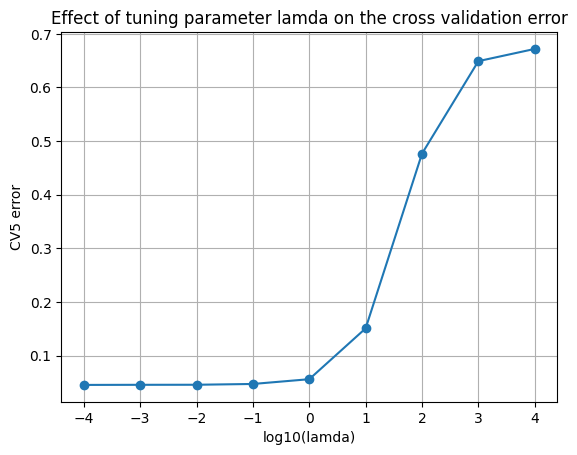

In [ ]:
#Illustrating the effect of the tuning parameters on the cross validation error
lamdas = [10**(-4),10**(-3),10**(-2),10**(-1),10**(0),10**(1),10**(2),10**(3),10**(4)]
plt.plot(np.log10(lamdas),lamda_entropy_values,marker='o')
plt.xlabel('log10(lamda)')
plt.ylabel('CV5 error')
plt.title('Effect of tuning parameter lamda on the cross validation error')
plt.grid(True)

In [ ]:
print(f'The optimal lamda 𝜆 with the smallest CV5 error of {best_entropy} is {best_lamda}')

The optimal lamda 𝜆 with the smallest CV5 error of 0.04539850849403806 is 0.0001


In [ ]:
#retraining the model with best lamda

X = data[['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']].values
Y_dummy = pd.get_dummies(data[['Ancestry']])
Y = Y_dummy.values
intercept = np.ones((N,1))

X_standardized = (X-np.mean(X,axis=0))/np.std(X,axis=0)
X_final = np.hstack((intercept,X_standardized))

beta = np.zeros((Params+1,5))
iterations = 10000
for i in range(iterations):
  U = np.exp(np.dot(X_final,beta))

  P = U/np.sum(U,axis=1,keepdims=True)

  Z = np.zeros_like(beta)
  Z[0,:] = beta[0,:]

  beta = beta + learning_rate*(np.dot(np.transpose(X_final),(Y-P))-2*best_lamda*(beta-Z))
beta_hat = beta

#leading the test data set
test_data = pd.read_csv("/content/drive/MyDrive/datasets/TestData_N111_p10.csv")

X_test = test_data[['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']].values
Y_test_dummy = pd.get_dummies(data[['Ancestry']])
Y_test = Y_test_dummy.values
intercept_test = np.ones((len(X_test),1))

X_test_standardized = (X_test-np.mean(X,axis=0))/np.std(X,axis=0)
X_test_final = np.hstack((intercept_test,X_test_standardized))

U_test = np.exp(np.dot(X_test_final,beta_hat))

P_test = U_test/np.sum(U_test,axis=1,keepdims=True)

pred = []
class1 = []
class2 = []
class3 = []
class4 = []
class5 = []

classes = ['African','EastAsian','European','NativeAmerican','Oceanian']

for i in range(len(P_test)):
  class1.append(P_test[i][0])
  class2.append(P_test[i][1])
  class3.append(P_test[i][2])
  class4.append(P_test[i][3])
  class5.append(P_test[i][4])
  pred.append(classes[np.argmax(P_test[i])])

print(f'Deliverable 4:\nThe Probabilities for each ancestry class and their most probable ancestry:\n')
for i in range(len(P_test)):
  print(f'Test sample {i+1}:')
  print(f'The probabilities for ancestry are {P_test[i]}')
  print(f'Most probable ancestry label: {classes[np.argmax(P_test[i])]}\n')


Deliverable 4:
The Probabilities for each ancestry class and their most probable ancestry:

Test sample 1:
The probabilities for ancestry are [0.00771457 0.00499731 0.00605764 0.00450725 0.97672324]
Most probable ancestry label: Oceanian

Test sample 2:
The probabilities for ancestry are [0.00190366 0.00310802 0.00896329 0.98325392 0.00277111]
Most probable ancestry label: NativeAmerican

Test sample 3:
The probabilities for ancestry are [0.0114209  0.03711075 0.93317462 0.00720165 0.01109208]
Most probable ancestry label: European

Test sample 4:
The probabilities for ancestry are [0.93112948 0.0058065  0.00921697 0.008714   0.04513305]
Most probable ancestry label: African

Test sample 5:
The probabilities for ancestry are [0.00269722 0.99000968 0.00124803 0.0044196  0.00162547]
Most probable ancestry label: EastAsian

Test sample 6:
The probabilities for ancestry are [0.01511196 0.00356574 0.07942306 0.89655466 0.00534457]
Most probable ancestry label: NativeAmerican

Test sample 7:

In [ ]:
result = pd.DataFrame(P_test, columns={'African': class1,'EastAsian': class2,'European': class3, 'NativeAmerican': class4, 'Oceanian': class5})
result['Most Probable Ancestry'] = pred
result

,African,EastAsian,European,NativeAmerican,Oceanian,Most Probable Ancestry
0,0.007715,0.004997,0.006058,0.004507,0.976723,Oceanian
1,0.001904,0.003108,0.008963,0.983254,0.002771,NativeAmerican
2,0.011421,0.037111,0.933175,0.007202,0.011092,European
3,0.931129,0.005807,0.009217,0.008714,0.045133,African
4,0.002697,0.990010,0.001248,0.004420,0.001625,EastAsian
...,...,...,...,...,...,...
106,0.970007,0.004712,0.006727,0.006742,0.011813,African
107,0.703038,0.028446,0.225698,0.016396,0.026422,African
108,0.889992,0.022207,0.029598,0.034793,0.023409,African
109,0.870540,0.006674,0.043985,0.052306,0.026495,African



*   From the test sample predictions we can see that the 5 unknown samples are predicted to be identical to one of the ancestry classes of 'Oceanian', 'NativeAmerican', 'European', 'African', 'EastAsian' each. While, the Mexicans samples are predicted to be of Native american ancestry or European ancestry and the AfricanAmerican samples are strongly predicted to be of African ancestry.<br>
<br>
*   The Mexicans samples being predicted as Native american can be explained as Mexicans and Native americans have a similar culture influnced by the ancient mexican empires like Aztec Empire and south american empires before the european colonization. The European colonization also has a big say in mexicans being predicted as Europeans mainly the Spanish colonization for Mexicans.So, there is a chance the unknown test samples 2 and 3 are of Mexican ancestry but are predicted as Native American and European respectively.<br>
<br>
*   The AfricanAmerican samples are predicted to be of African ancestry as most of the African-american ancestors have been the immigrants from Africa. so the input principal components data for AfricanAmerican samples might have a lot of similarities to the African ancestry. There is a chance the unknown test sample 4 is also of AfricanAmcerican ancestry but is predicted as African.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(X)
y_train = data[['Ancestry']].values
beta_values = []
for lamda in lamda_values:
  model = LogisticRegression(solver='lbfgs',C=1/lamda,tol=learning_rate,max_iter=10000)
  model.fit(x_train,y_train)
  beta_values.append(np.transpose(model.coef_))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

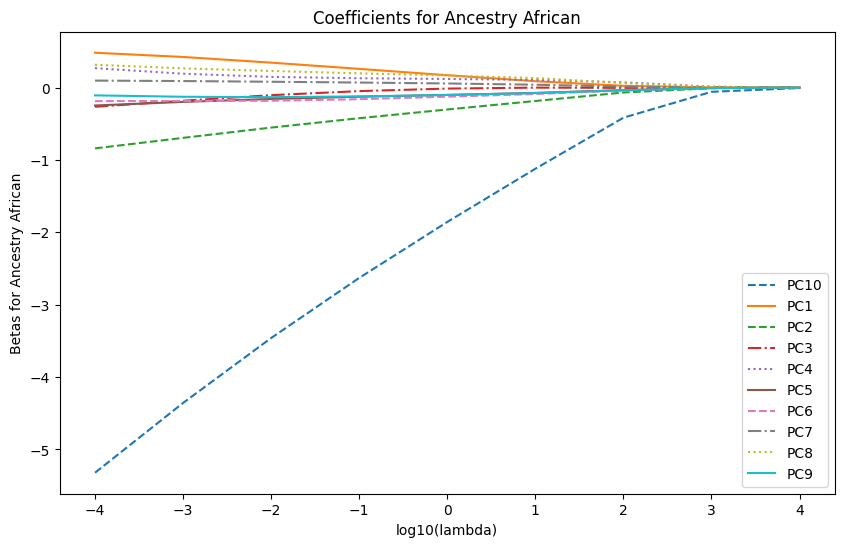

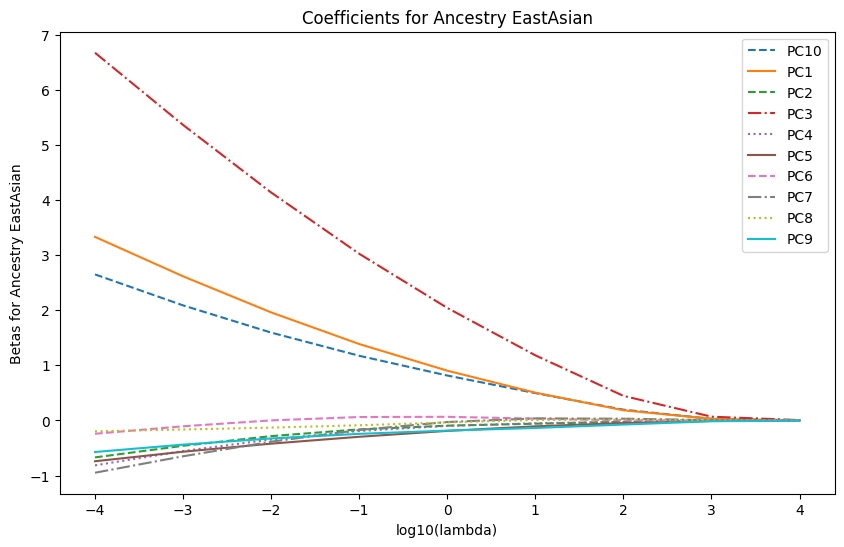

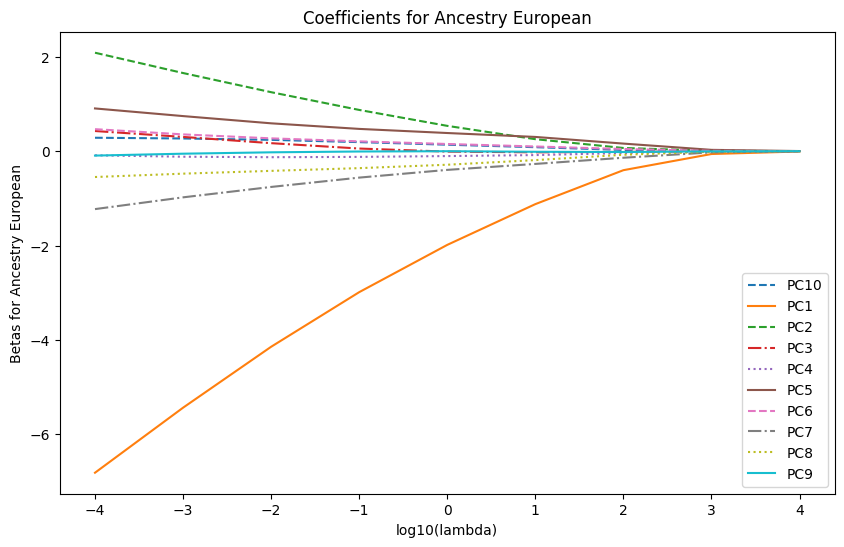

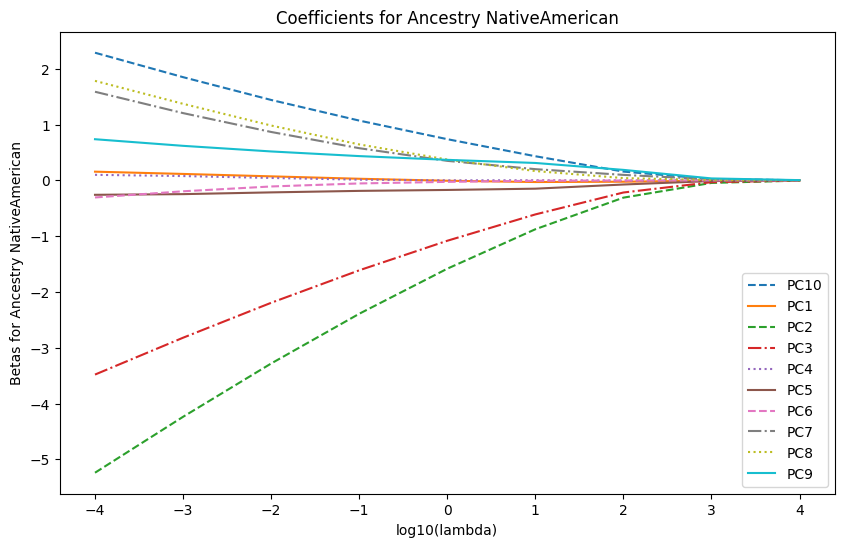

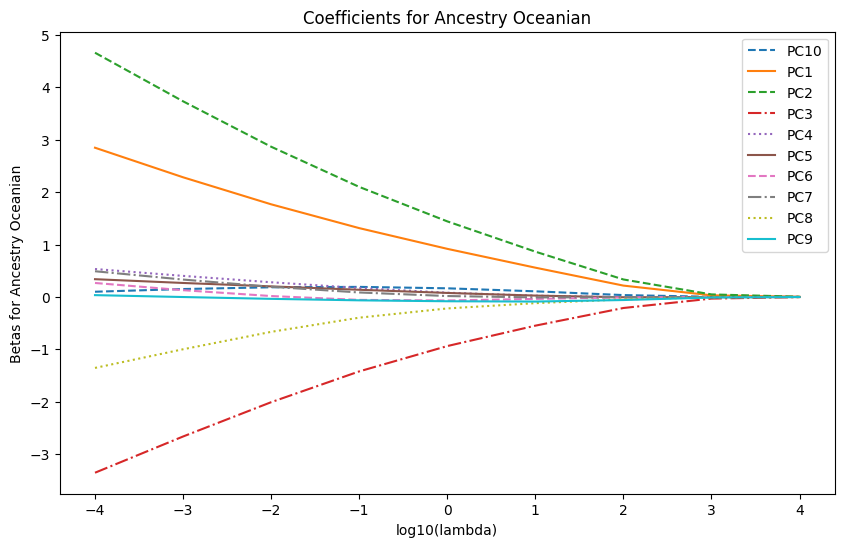

In [ ]:
beta_values = np.array(beta_values)
classes = ['African','EastAsian','European','NativeAmerican','Oceanian']
feature_labels = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']
line_model = ['-','--','-.',':','-','--','-.',':','-','--']
for k in range(K):
    plt.figure(figsize=(10, 6))
    for j in range(len(feature_labels)):
        plt.plot(np.log10(lamda_values), beta_values[:, j, k], linestyle=line_model[j-1], label=f'{feature_labels[j-1]}')
    plt.xlabel('log10(lambda)')
    plt.ylabel(f'Betas for Ancestry {classes[k]}')
    plt.title(f'Coefficients for Ancestry {classes[k]}')
    plt.legend()
    plt.show()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

best_entropy = float('inf')
best_lamda = 0
lamda_entropy_values = []
for lamda in lamda_values:
  entropy_values = []
  for train_index, val_index in kf.split(x_train):
    X_train, X_val = x_train[train_index], x_train[val_index]
    Y_train, Y_val = y_train[train_index], y_train[val_index]

    X_train = scaler.fit_transform(X_train)
    X_val = scaler.fit_transform(X_val)

    model = LogisticRegression(solver='lbfgs',C=1/lamda,tol=learning_rate,max_iter=10000)
    model.fit(X_train, Y_train)

    P_val = model.predict_proba(X_val)
    log_loss_value = log_loss(Y_val,P_val)
    entropy_values.append(log_loss_value)
  loss_CV_avg = np.mean(entropy_values)
  lamda_entropy_values.append(loss_CV_avg)
  if(loss_CV_avg<best_entropy):
    best_entropy = loss_CV_avg
    best_lamda = lamda
best_entropy,best_lamda

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

(0.0018919817483889947, 0.0001)

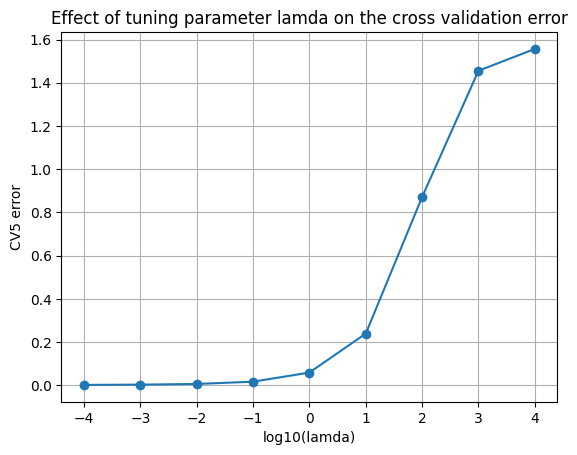

In [ ]:
lamdas = [10**(-4),10**(-3),10**(-2),10**(-1),10**(0),10**(1),10**(2),10**(3),10**(4)]
plt.plot(np.log10(lamdas),lamda_entropy_values,marker='o')
plt.xlabel('log10(lamda)')
plt.ylabel('CV5 error')
plt.title('Effect of tuning parameter lamda on the cross validation error')
plt.grid(True)

In [ ]:
print(f'The optimal lamda 𝜆 with the smallest CV5 error of {best_entropy} is {best_lamda}')

The optimal lamda 𝜆 with the smallest CV5 error of 0.0018919817483889947 is 0.0001


In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(X)
y_train = data[['Ancestry']].values
model = LogisticRegression(solver='lbfgs',C=1/best_lamda,tol=learning_rate,max_iter=10000)
model.fit(x_train,y_train)

Y_test = test_data[['Ancestry']].values
X_test_standardized = (X_test-np.mean(X))/np.std(X)

P_test = model.predict_proba(X_test_standardized)
pred_test = []
class1_test = []
class2_test = []
class3_test = []
class4_test = []
class5_test = []

classes_test = ['African','EastAsian','European','NativeAmerican','Oceanian']

for i in range(len(P_test)):
  class1_test.append(P_test[i][0])
  class2_test.append(P_test[i][1])
  class3_test.append(P_test[i][2])
  class4_test.append(P_test[i][3])
  class5_test.append(P_test[i][4])
  pred_test.append(classes[np.argmax(P_test[i])])

print(f'Deliverable 4:\nThe Probabilities for each ancestry class and their most probable ancestry:\n')
for i in range(len(P_test)):
  print(f'Test sample {i+1}:')
  print(f'The probabilities for ancestry are {P_test[i]}')
  print(f'Most probable ancestry label: {classes_test[np.argmax(P_test[i])]}\n')


Deliverable 4:
The Probabilities for each ancestry class and their most probable ancestry:

Test sample 1:
The probabilities for ancestry are [7.10879404e-13 1.90102909e-12 1.26333206e-13 9.48072134e-14
 1.00000000e+00]
Most probable ancestry label: Oceanian

Test sample 2:
The probabilities for ancestry are [2.03016119e-13 1.03815947e-09 1.40832825e-12 9.99999999e-01
 6.94954892e-12]
Most probable ancestry label: NativeAmerican

Test sample 3:
The probabilities for ancestry are [2.91792566e-06 1.90506565e-04 9.99805161e-01 3.49458372e-07
 1.06554398e-06]
Most probable ancestry label: European

Test sample 4:
The probabilities for ancestry are [9.99999984e-01 5.39507711e-14 1.37361843e-13 1.26135047e-13
 1.60024697e-08]
Most probable ancestry label: African

Test sample 5:
The probabilities for ancestry are [4.36726465e-14 1.00000000e+00 8.30561947e-15 1.25799038e-10
 4.61578205e-14]
Most probable ancestry label: EastAsian

Test sample 6:
The probabilities for ancestry are [1.25262442e

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
result = pd.DataFrame(P_test, columns={'African': class1_test,'EastAsian': class2_test,'European': class3_test, 'NativeAmerican': class4_test, 'Oceanian': class5_test})
result['Most Probable Ancestry'] = pred_test
result

,African,EastAsian,European,NativeAmerican,Oceanian,Most Probable Ancestry
0,7.108794e-13,1.901029e-12,1.263332e-13,9.480721e-14,1.000000e+00,Oceanian
1,2.030161e-13,1.038159e-09,1.408328e-12,1.000000e+00,6.949549e-12,NativeAmerican
2,2.917926e-06,1.905066e-04,9.998052e-01,3.494584e-07,1.065544e-06,European
3,1.000000e+00,5.395077e-14,1.373618e-13,1.261350e-13,1.600247e-08,African
4,4.367265e-14,1.000000e+00,8.305619e-15,1.257990e-10,4.615782e-14,EastAsian
...,...,...,...,...,...,...
106,1.000000e+00,3.467232e-14,1.678957e-13,5.043439e-13,9.819453e-11,African
107,9.999998e-01,2.267019e-09,1.515236e-07,2.145392e-10,2.831415e-09,African
108,1.000000e+00,7.441327e-11,9.768989e-12,5.825335e-10,5.858685e-10,African
109,9.999997e-01,1.765554e-11,3.328548e-08,2.670628e-07,2.285830e-08,African



*   From the test sample predictions we can see that the 5 unknown samples are predicted to be identical to one of the ancestry classes of 'Oceanian', 'NativeAmerican', 'European', 'African', 'EastAsian' each. While, the Mexicans samples are predicted to be of Native american ancestry or European ancestry and the AfricanAmerican samples are strongly predicted to be of African ancestry.<br>
<br>
*   The Mexicans samples being predicted as Native american can be explained as Mexicans and Native americans have a similar culture influnced by the ancient mexican empires like Aztec Empire and south american empires before the european colonization. The European colonization also has a big say in mexicans being predicted as Europeans mainly the Spanish colonization for Mexicans.So, there is a chance the unknown test samples 2 and 3 are of Mexican ancestry but are predicted as Native American and European respectively.<br>
<br>
*   The AfricanAmerican samples are predicted to be of African ancestry as most of the African-american ancestors have been the immigrants from Africa. so the input principal components data for AfricanAmerican samples might have a lot of similarities to the African ancestry. There is a chance the unknown test sample 4 is also of AfricanAmcerican ancestry but is predicted as African.



